In [136]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

device = torch.device("mps" if torch.mps.is_available() else "cpu")

In [137]:
df = pd.read_csv('fall_pose_keypoint_v2.csv')
df.head()

,image_name,label,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,poepoes (7).jpg,needhelp,0.802498,0.561774,0.813926,0.562861,0.819918,0.544108,0.814199,0.565528,...,0.518126,0.496779,0.384694,0.551551,0.379427,0.505839,0.234543,0.503823,0.221133,0.427620
1,people-1671-_jpg.rf.721c4272719dbac3265bbb8a7a50e4a5.jpg,needhelp,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.049140,0.096838,0.036475,0.216825,0.056460,0.221321,0.051879,0.373114,0.061669,0.382340
2,people-1671-_jpg.rf.721c4272719dbac3265bbb8a7a50e4a5.jpg,needhelp,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.236854,0.078964,0.199388,0.161084,0.247893,0.161160,0.164344,0.252980,0.273755,0.252240
3,people-1671-_jpg.rf.721c4272719dbac3265bbb8a7a50e4a5.jpg,needhelp,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.981390,0.259671,0.982661,0.260302,0.947703,0.360081,0.953294,0.361626
4,people-1671-_jpg.rf.721c4272719dbac3265bbb8a7a50e4a5.jpg,needhelp,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.797548,0.024245,0.820755,0.100652,0.795297,0.101185,0.804242,0.171119,0.787399,0.173734


In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image_name        455 non-null    object 
 1   label             455 non-null    object 
 2   nose_x            455 non-null    float64
 3   nose_y            455 non-null    float64
 4   left_eye_x        455 non-null    float64
 5   left_eye_y        455 non-null    float64
 6   right_eye_x       455 non-null    float64
 7   right_eye_y       455 non-null    float64
 8   left_ear_x        455 non-null    float64
 9   left_ear_y        455 non-null    float64
 10  right_ear_x       455 non-null    float64
 11  right_ear_y       455 non-null    float64
 12  left_shoulder_x   455 non-null    float64
 13  left_shoulder_y   455 non-null    float64
 14  right_shoulder_x  455 non-null    float64
 15  right_shoulder_y  455 non-null    float64
 16  left_elbow_x      455 non-null    float64
 1

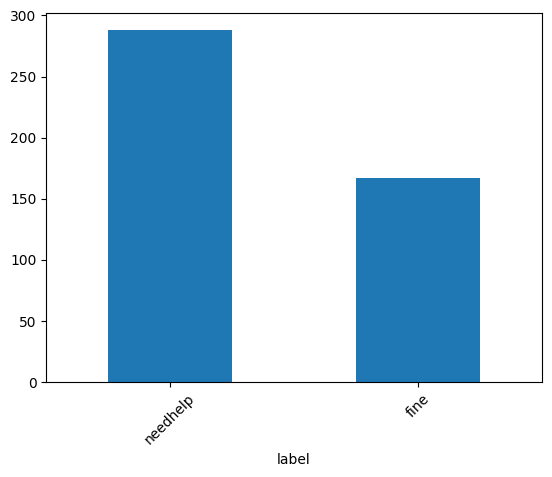

In [139]:
df.label.value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show()

In [140]:
encoder = LabelEncoder()
y_label = df['label']
y = encoder.fit_transform(y_label)
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [141]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights

array([1.36227545, 0.78993056])

In [142]:
X = df.iloc[:,12:]
X

,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,0.737621,0.603241,0.748894,0.569644,0.667450,0.695868,0.660114,0.690150,0.596473,0.810467,...,0.518126,0.496779,0.384694,0.551551,0.379427,0.505839,0.234543,0.503823,0.221133,0.427620
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.084541,0.045062,0.000000,0.000000,...,0.049140,0.096838,0.036475,0.216825,0.056460,0.221321,0.051879,0.373114,0.061669,0.382340
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.171284,0.021137,0.000000,0.000000,...,0.236854,0.078964,0.199388,0.161084,0.247893,0.161160,0.164344,0.252980,0.273755,0.252240
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.981390,0.259671,0.982661,0.260302,0.947703,0.360081,0.953294,0.361626
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.797548,0.024245,0.820755,0.100652,0.795297,0.101185,0.804242,0.171119,0.787399,0.173734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,0.594235,0.659185,0.505238,0.649343,0.668350,0.708480,0.474453,0.745726,0.779290,0.725125,...,0.523627,0.802135,0.625487,0.846450,0.604611,0.841912,0.683063,0.938181,0.694631,0.936143
451,0.496982,0.236859,0.407661,0.222786,0.488561,0.340682,0.380669,0.308000,0.449925,0.371222,...,0.496603,0.289264,0.508971,0.421559,0.469300,0.413817,0.510707,0.582183,0.497219,0.574109
452,0.261371,0.413688,0.461764,0.422827,0.252134,0.595633,0.501921,0.617160,0.307776,0.714301,...,0.503409,0.648947,0.601380,0.675591,0.696195,0.684788,0.846905,0.690198,0.849311,0.694144
453,0.313163,0.484568,0.137242,0.555459,0.397813,0.564712,0.141219,0.681107,0.322517,0.656164,...,0.433086,0.663004,0.765346,0.540039,0.704348,0.599524,0.882335,0.558184,0.876478,0.591071


In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=2022)

print("Number of Training keypoints: ", len(X_train))
print("Number of Testing keypoints: ", len(X_test))

Number of Training keypoints:  364
Number of Testing keypoints:  91


In [144]:
scaler = MinMaxScaler()

In [145]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test

array([[0.21089646, 0.73605159, 0.20885267, ..., 0.76751035, 0.84299006,
        0.77841611],
       [0.84429365, 0.91318913, 0.36132634, ..., 0.        , 0.        ,
        0.        ],
       [0.66627073, 0.94070668, 0.23023562, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.64260024, 0.25628811, 0.45901929, ..., 0.96515797, 0.47861468,
        0.9429611 ],
       [0.        , 0.        , 0.        , ..., 0.28139815, 0.82805958,
        0.27589744],
       [0.        , 0.        , 0.        , ..., 0.52185346, 0.95558333,
        0.51556384]])

In [146]:
class DataKeypointClassification(Dataset):
    def __init__(self, X, y):
        self.x = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.int64))
        self.n_samples = X.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

In [147]:
train_dataset = DataKeypointClassification(X_train, y_train)
test_dataset = DataKeypointClassification(X_test, y_test)

In [148]:
batch_size = 12
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [149]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

In [150]:
hidden_size = 256
model = NeuralNet(X_train.shape[1], hidden_size, len(class_weights))
print(X_train.shape[1])

24


In [151]:
len(class_weights)

2

In [152]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(class_weights.astype(np.float32)))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [153]:
num_epoch = 100
for epoch in range(num_epoch):
    train_acc = 0
    train_loss = 0
    loop = tqdm(train_loader)
    for idx, (features, labels) in enumerate(loop):
        outputs = model(features)
        loss = criterion(outputs, labels)

        predictions = outputs.argmax(dim=1, keepdim=True).squeeze()
        correct = (predictions == labels).sum().item()
        accuracy = correct / batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch [{epoch}/{num_epoch}]")
        loop.set_postfix(loss=loss.item(), acc=accuracy)

Epoch [49/100]:   0%|          | 0/31 [00:00<?, ?it/s, acc=1, loss=0.0254]   IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch [99/100]: 100%|██████████| 31/31 [00:00<00:00, 599.89it/s, acc=0.333, loss=0.00777]


In [154]:
test_features = torch.from_numpy(X_test.astype(np.float32))
test_labels = y_test
with torch.no_grad():
    outputs = model(test_features)
    _, predictions = torch.max(outputs, 1)
predictions

tensor([1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1])

In [155]:
print(classification_report(test_labels, predictions, target_names=encoder.classes_))

              precision    recall  f1-score   support

        fine       0.81      0.76      0.78        33
    needhelp       0.87      0.90      0.88        58

    accuracy                           0.85        91
   macro avg       0.84      0.83      0.83        91
weighted avg       0.84      0.85      0.85        91



In [156]:
PATH_SAVE = '../../../../../data/weights/yolo_pose_nnClassifier/pose_classification_v3.pt'
torch.save(model.state_dict(), PATH_SAVE)

In [157]:
model_inference =  NeuralNet(
        X_train.shape[1], 
        hidden_size, 
        len(class_weights)
    )

model_inference.load_state_dict(
        torch.load(PATH_SAVE, map_location=device)
    )

/var/folders/f6/cqgl3gc517zb0rzw3ms24b9r0000gn/T/ipykernel_86703/1259055062.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(PATH_SAVE, map_location=device)


<All keys matched successfully>

In [158]:
feature, label = test_dataset.__getitem__(69)

out = model_inference(feature)
_, predict = torch.max(out, -1)
print(f'\
    prediction label : {encoder.classes_[predict]} \n\
    ground thrut label : {encoder.classes_[label]}'
    )

    prediction label : needhelp 
    ground thrut label : needhelp
